We preprocess the data from Chen et al., Nature Immunology 2024

In [1]:
import pandas as pd

In [2]:
data = "../data/dt_All_bin_50_wCopyNumber_20220114.csv"
df = pd.read_csv(data)
df

,Window.ID,X,Y,Counts CD8+,Counts PD1+,Counts CD8+PD1+,Counts CD8+Ki67+,Counts CD8+TCF7+,Counts CD8+TCF7+Ki67+,Counts CD8+PD1+Ki67+,...,i.Copies CXCL10.11,i.Copies IFNG,i.Copies CD3E,i.Slide.id.Ab,i.Shuffled,Counts.CXCL10.11.bin,Xbin,Ybin,bin,nbins
0,315,25.744,16207.360,0,0,0,0,0,0,0,...,0,0,0,2e79_08,0,0,0,0,0,1
1,316,25.744,16257.360,0,0,0,0,0,0,0,...,0,0,0,2e79_08,0,0,0,0,0,1
2,317,25.744,16307.360,0,0,0,0,0,0,0,...,0,0,0,2e79_08,0,0,0,0,0,1
3,318,25.744,16357.360,0,0,0,0,0,0,0,...,0,0,0,2e79_08,0,0,0,0,0,1
4,319,25.744,16407.360,0,0,0,0,0,0,0,...,0,0,0,2e79_08,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
865790,64778,24300.752,16268.008,0,0,0,0,0,0,0,...,0,0,0,2e80_02,0,0,0,0,0,1
865791,64781,24300.752,16418.008,0,0,0,0,0,0,0,...,0,0,0,2e80_02,0,0,0,0,0,1
865792,64782,24300.752,16468.008,0,0,0,0,0,0,0,...,0,0,0,2e80_02,0,0,0,0,0,1
865793,64783,24300.752,16518.008,0,0,0,0,0,0,0,...,0,0,0,2e80_02,0,0,0,0,0,1


#### Explorations

In [3]:
df.columns

Index(['Window.ID', 'X', 'Y', 'Counts CD8+', 'Counts PD1+', 'Counts CD8+PD1+',
       'Counts CD8+Ki67+', 'Counts CD8+TCF7+', 'Counts CD8+TCF7+Ki67+',
       'Counts CD8+PD1+Ki67+',
       ...
       'i.Copies CXCL10.11', 'i.Copies IFNG', 'i.Copies CD3E', 'i.Slide.id.Ab',
       'i.Shuffled', 'Counts.CXCL10.11.bin', 'Xbin', 'Ybin', 'bin', 'nbins'],
      dtype='object', length=127)

In [4]:
df["Response"].value_counts()

Response
NR    623461
R     242334
Name: count, dtype: int64

In [5]:
df["Slide.id.Ab"].nunique()

46

In [6]:
df["Slide.id.Ab"].value_counts()

Slide.id.Ab
2e80_09    95007
2e77_08    55811
2e79_06    53534
2e74_03    53387
2e81_03    50406
2e77_10    50219
2e75_01    50213
2e79_10    46291
2e83_08    42994
2e82_07    42004
2e79_11    34648
2e80_02    29617
2e79_08    28813
2e77_09    28646
2e79_03    24800
2e74_06    21883
2e82_03    17808
2e77_02    16866
2e74_02    12412
2e80_04    11234
2e75_11    10736
2e74_01     9748
2e77_11     8731
2e82_02     8064
2e82_01     7538
2e81_08     7036
2e77_16     6520
2e77_15     5397
2e82_04     5273
2e74_05     3293
2e83_07     3152
2e80_05     2569
2e77_14     2550
2e75_06     2419
2e77_07     2303
2e77_04     2148
2e77_01     2103
2e77_06     2030
2e79_07     1659
2e77_13     1470
2e83_06     1091
2e81_01     1025
2e79_02      781
2e75_09      715
2e75_07      502
2e82_08      349
Name: count, dtype: int64

In [7]:
df["Slide.id.Ab"].value_counts().sum()

np.int64(865795)

#### Processing into X

In [14]:
df["Counts CD8+"].describe()

count    865795.000000
mean          0.613406
std           1.576024
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          36.000000
Name: Counts CD8+, dtype: float64

In [15]:
# see if there are X, Y duplicates
df_duplicates = df[df.duplicated(subset=["X", "Y"], keep=False)]
df_duplicates.shape

(0, 127)

In [68]:
import numpy as np
import pandas as pd
from typing import Dict
from pathlib import Path

output_dir = Path("/Users/jamesbolepan/Documents/cancer-immune-simulations/data/nature_immune_processed")

def build_slide_grids_checked(
    df: pd.DataFrame,
    slide_col: str = "Slide.id.Ab",
    xbin_col: str = "X",
    ybin_col: str = "Y",
    save: bool = True,
) -> Dict[str, np.ndarray]:
    """
    For each unique slide, construct a [rows, cols, 3] array with channels [C, T, A].

    - T cell counts are summed from all columns whose names contain "Counts CD8+".
    - Cancer cell counts are summed from all columns whose names contain "Counts CK".
    - Missing spatial grids (X,Y) are filled with 0.
    - Saves each slide's grid as a .npy file in output_dir (no subfolders).
    - Performs consistency checks on grid counts and max values.
    """

    # ---- auto-detect relevant columns ----
    cd8_cols = [c for c in df.columns if "Counts CD8+" in c and "NormCounts" not in c and "i.Counts" not in c]
    ck_cols  = [c for c in df.columns if "Counts CK" in c and "NormCounts" not in c and "i.Counts" not in c]

    if not cd8_cols:
        raise ValueError("No columns found containing 'Counts CD8+'")
    if not ck_cols:
        raise ValueError("No columns found containing 'Counts CK'")

    print(f"[INFO] Using {len(cd8_cols)} CD8+ columns: {cd8_cols}")
    print(f"[INFO] Using {len(ck_cols)} CK columns: {ck_cols}")

    # ---- prepare output ----
    grids: Dict[str, np.ndarray] = {}
    total_grids = 0
    all_grid_t_max = -np.inf
    all_grid_c_max = -np.inf

    # ---- ensure output directory exists ----
    if save:
        output_dir.mkdir(parents=True, exist_ok=True)

    # ---- build grids per slide ----
    for slide_id, g in df.groupby(slide_col, dropna=False):
        g = g.copy()
        g["T_sum"] = g[cd8_cols].sum(axis=1, skipna=True)
        g["C_sum"] = g[ck_cols].sum(axis=1, skipna=True)

        # unique spatial coordinates
        xs = np.sort(g[xbin_col].unique())
        ys = np.sort(g[ybin_col].unique())
        rows, cols = len(ys), len(xs)

        # pivot and reindex to ensure full grid coverage
        T_mat = (
            g.pivot(index=ybin_col, columns=xbin_col, values="T_sum")
             .reindex(index=ys, columns=xs)
             .fillna(0.0)
        )
        C_mat = (
            g.pivot(index=ybin_col, columns=xbin_col, values="C_sum")
             .reindex(index=ys, columns=xs)
             .fillna(0.0)
        )

        # 3D array [rows, cols, 3]
        grid = np.zeros((rows, cols, 3), dtype=float)
        grid[:, :, 0] = C_mat.to_numpy()  # Cancer
        grid[:, :, 1] = T_mat.to_numpy()  # T cells
        grid[:, :, 2] = 0.0               # Drug placeholder

        grids[str(slide_id)] = grid

        # track stats
        total_grids += rows * cols
        all_grid_t_max = max(all_grid_t_max, grid[:, :, 1].max())
        all_grid_c_max = max(all_grid_c_max, grid[:, :, 0].max())

        # ---- save directly into output_dir ----
        if save:
            # sanitize filename
            safe_name = str(slide_id).replace("/", "_").replace(" ", "_")
            save_path = output_dir / f"{safe_name}.npy"
            np.save(save_path, grid)
            print(f"[SAVED] {slide_id}: grid shape={grid.shape} → {save_path}")

    # ---- global consistency checks ----
    n_unique_grids = len(df.drop_duplicates([slide_col, xbin_col, ybin_col]))
    df_t_max = pd.to_numeric(df[cd8_cols].sum(axis=1), errors="coerce").max()
    df_c_max = pd.to_numeric(df[ck_cols].sum(axis=1), errors="coerce").max()

    errors = []
    if total_grids < n_unique_grids:
        errors.append(
            f"Total expected grid positions ({total_grids}) < number of unique (slide,X,Y) = {n_unique_grids}. "
            "Some spatial bins may be missing or misaligned."
        )
    if not np.isclose(all_grid_t_max, df_t_max, rtol=1e-6, atol=1e-6):
        errors.append(f"Max T mismatch: grid={all_grid_t_max}, df={df_t_max}")
    if not np.isclose(all_grid_c_max, df_c_max, rtol=1e-6, atol=1e-6):
        errors.append(f"Max Cancer mismatch: grid={all_grid_c_max}, df={df_c_max}")

    if errors:
        raise AssertionError(" | ".join(errors))

    print(f"[CHECK PASSED] Grids built for {len(grids)} slides. "
          f"Total expected grids={total_grids}, unique (slide,X,Y)={n_unique_grids}, "
          f"max T={all_grid_t_max}, max C={all_grid_c_max}")

    return grids


In [69]:
grids = build_slide_grids_checked(df)

[INFO] Using 15 CD8+ columns: ['Counts CD8+', 'Counts CD8+PD1+', 'Counts CD8+Ki67+', 'Counts CD8+TCF7+', 'Counts CD8+TCF7+Ki67+', 'Counts CD8+PD1+Ki67+', 'Counts CD8+PD1+TCF7+', 'Counts CD8+PD1+Ki67+TCF7+', 'Counts CD8+PD1+Ki67-TCF7+', 'Counts CD8+PD1-Ki67+TCF7+', 'Counts CD8+PD1-Ki67-TCF7+', 'Counts CD8+PD1+Ki67+TCF7-', 'Counts CD8+PD1+Ki67-TCF7-', 'Counts CD8+PD1-Ki67+TCF7-', 'Counts CD8+PD1-Ki67-TCF7-']
[INFO] Using 11 CK columns: ['Counts CK.ab+', 'Counts CK.ab+PDL1+', 'Counts CK.ab+PDL1-', 'Counts CK.ab-PDL1-', 'Counts CK.ab-PDL1+', 'Counts CK.ab+TCF7+', 'Counts CK.ish+CXCL10.11+', 'Counts CK.ish+CXCL10.11-', 'Counts CK.ish-CXCL10.11+', 'Counts CK.ish-CXCL10.11-', 'Counts CK.ish+']
[SAVED] 2e74_01: grid shape=(156, 116, 3) → /Users/jamesbolepan/Documents/cancer-immune-simulations/data/nature_immune_processed/2e74_01.npy
[SAVED] 2e74_02: grid shape=(168, 136, 3) → /Users/jamesbolepan/Documents/cancer-immune-simulations/data/nature_immune_processed/2e74_02.npy
[SAVED] 2e74_03: grid 

In [70]:
grids

{'2e74_01': array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], shape=(156, 116, 3)),
 '2e74_02': array([[[0.

#### Survival data

In [11]:
response_df = df[["Slide.id.Ab", "Response"]].drop_duplicates().reset_index(drop=True)
response_df

,Slide.id.Ab,Response
0,2e79_08,NR
1,2e77_14,NR
2,2e77_06,NR
3,2e81_01,NR
4,2e77_10,NR
5,2e77_16,R
6,2e75_06,NR
7,2e79_10,R
8,2e75_01,NR
9,2e80_09,NR


In [12]:
# save response_df
response_save_path = "/Users/jamesbolepan/Documents/cancer-immune-simulations/data/nature_immune_processed/slide_responses.csv"
response_df.to_csv(response_save_path, index=False)

#### validate output

In [18]:
cd8_cols = [c for c in df.columns if "Counts CD8+" in c and "NormCounts" not in c and "i.Counts" not in c]
ck_cols  = [c for c in df.columns if "Counts CK" in c and "NormCounts" not in c and "i.Counts" not in c]

In [21]:
sample_id = "2e77_08"
df_filtered = df[df["Slide.id.Ab"] == sample_id].copy()
df_filtered["T_sum"] = df_filtered[cd8_cols].sum(axis=1, skipna=True)
df_filtered["C_sum"] = df_filtered[ck_cols].sum(axis=1, skipna=True)
t_sum_all = df_filtered["T_sum"].sum()
c_sum_all = df_filtered["C_sum"].sum()
print(f"For sample {sample_id}: Total T sum = {t_sum_all}, Total C sum = {c_sum_all}")

For sample 2e77_08: Total T sum = 34862, Total C sum = 1283615


#### Find the 10 smallest data

In [7]:
import os
import numpy as np
import csv

folder = "/Users/jamesbolepan/Documents/cancer-immune-simulations/data/nature_immune_processed"

files = [f for f in os.listdir(folder) if f.endswith(".npy")]

# Store shapes
dims = []
for f in files:
    full_path = os.path.join(folder, f)
    try:
        arr = np.load(full_path, mmap_mode='r')
        shape = arr.shape
        
        # Use only the first two dimensions
        if len(shape) >= 2:
            key = shape[0] * shape[1]
        else:
            key = float("inf")

        dims.append((f, full_path, shape, key))
    except Exception as e:
        dims.append((f, full_path, None, str(e)))

# Sort by the product of first two dimensions (smallest to largest)
dims_sorted = sorted(dims, key=lambda x: x[3] if isinstance(x[3], (int, float)) else float('inf'))

# Print results
for f, path, shape, key in dims_sorted:
    print(f"{f}: shape={shape}, first_two_product={key}")

# Save to CSV
csv_path = "npy_dimensions_sorted.csv"
with open(csv_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["filename", "full_path", "shape", "first_two_product"])
    for f, path, shape, key in dims_sorted:
        writer.writerow([f, path, str(shape), key])

print(f"\nCSV saved to: {csv_path}")

2e82_08.npy: shape=(49, 38, 3), first_two_product=1862
2e79_02.npy: shape=(42, 58, 3), first_two_product=2436
2e83_06.npy: shape=(79, 41, 3), first_two_product=3239
2e75_09.npy: shape=(67, 52, 3), first_two_product=3484
2e81_01.npy: shape=(89, 46, 3), first_two_product=4094
2e75_06.npy: shape=(55, 79, 3), first_two_product=4345
2e79_07.npy: shape=(47, 110, 3), first_two_product=5170
2e75_07.npy: shape=(83, 64, 3), first_two_product=5312
2e77_13.npy: shape=(104, 66, 3), first_two_product=6864
2e77_04.npy: shape=(124, 57, 3), first_two_product=7068
2e77_06.npy: shape=(126, 65, 3), first_two_product=8190
2e77_01.npy: shape=(103, 82, 3), first_two_product=8446
2e74_05.npy: shape=(113, 88, 3), first_two_product=9944
2e80_05.npy: shape=(123, 89, 3), first_two_product=10947
2e82_04.npy: shape=(100, 114, 3), first_two_product=11400
2e82_01.npy: shape=(116, 111, 3), first_two_product=12876
2e77_07.npy: shape=(114, 125, 3), first_two_product=14250
2e82_02.npy: shape=(134, 129, 3), first_two_prod

#### Examining running results

In [12]:
results = "/Users/jamesbolepan/Documents/cancer-immune-simulations/test_clinical_data_visualization_20251126/summary_results.csv"
df_results = pd.read_csv(results)
df_results.head()

,sample_id,ground_truth,predicted,initial_cancer,final_cancer,initial_tcells,final_tcells,pct_change_cancer,pct_change_tcells,trajectory_path,correct
0,2e82_08,R,R,16955.0,16408.287101,2063.0,6600.431655,-3.224494,219.943367,test_clinical_data_visualization/2e82_08_X_Num...,True
1,2e79_02,NR,R,21922.0,18814.450801,1739.0,8094.257415,-14.175482,365.454710,test_clinical_data_visualization/2e79_02_X_Num...,False
2,2e83_06,R,R,36205.0,22727.933810,738.0,12042.821419,-37.224323,1531.818620,test_clinical_data_visualization/2e83_06_X_Num...,True
3,2e75_09,NR,NR,23073.0,23360.403379,4860.0,8934.811300,1.245626,83.843854,test_clinical_data_visualization/2e75_09_X_Num...,True
4,2e81_01,NR,NR,14245.0,28329.696551,209.0,10598.916560,98.874669,4971.251942,test_clinical_data_visualization/2e81_01_X_Num...,True


In [13]:
df = df_results.copy()

# Define positive = R, negative = NR
gt = df["ground_truth"]
pred = df["predicted"]

# Confusion matrix components
TP = ((gt == "R") & (pred == "R")).sum()
TN = ((gt == "NR") & (pred == "NR")).sum()
FP = ((gt == "NR") & (pred == "R")).sum()
FN = ((gt == "R") & (pred == "NR")).sum()

# Rates
TPR = TP / (TP + FN) if (TP + FN) > 0 else float('nan')
TNR = TN / (TN + FP) if (TN + FP) > 0 else float('nan')

print("Confusion Matrix:")
print(f"TP = {TP}")
print(f"TN = {TN}")
print(f"FP = {FP}")
print(f"FN = {FN}\n")

print(f"True Positive Rate (Sensitivity): {TPR:.3f}")
print(f"True Negative Rate (Specificity): {TNR:.3f}")

Confusion Matrix:
TP = 13
TN = 4
FP = 29
FN = 0

True Positive Rate (Sensitivity): 1.000
True Negative Rate (Specificity): 0.121


In [14]:
conf_mat = pd.crosstab(gt, pred, rownames=['Ground Truth'], colnames=['Predicted'])
conf_mat

Predicted,NR,R
Ground Truth,,
NR,4,29
R,0,13


In [15]:
df_results["ground_truth"].value_counts()

ground_truth
NR    33
R     13
Name: count, dtype: int64

In [18]:
df_results.head(15)["ground_truth"].value_counts()

ground_truth
NR    11
R      4
Name: count, dtype: int64

#### Training curves plotting

In [3]:
history = "/Users/jamesbolepan/Documents/cancer-immune-simulations/final_report_drug_modeling_counterfactual_minpath/training_history.csv"
df_history = pd.read_csv(history)
print(f"Shape of training history: {df_history.shape}")
df_history.head()

Shape of training history: (32, 12)


,train_loss,val_loss,train_acc_drug,val_acc_drug,train_acc_nodrug,val_acc_nodrug,train_benefit_R,val_benefit_R,alpha_drug_cls,beta_baseline,gamma,evaluated
0,21.253559,59.601501,0.71875,0.714286,0.96875,0.785714,0.0,0.0,1.0,0.3,0.1,True
1,20.063137,57.714401,0.68750,0.714286,0.93750,0.785714,0.0,0.0,1.0,0.3,0.1,True
2,18.846514,55.445343,0.71875,0.714286,0.90625,0.785714,0.0,0.0,1.0,0.3,0.1,True
3,17.340214,53.177067,0.75000,0.714286,0.87500,0.785714,0.0,0.0,1.0,0.3,0.1,True
4,15.651754,51.085075,0.75000,0.714286,0.87500,0.785714,0.0,0.0,1.0,0.3,0.1,True


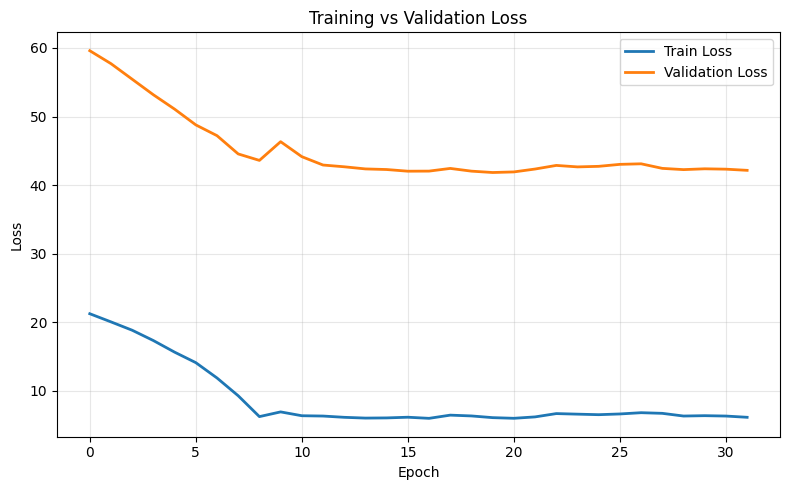

In [4]:
import matplotlib.pyplot as plt

df = df_history.copy()

# Extract numeric losses
train_loss = df['train_loss'].astype(float)

# Mask out NaNs in val_loss
val_mask = df['val_loss'].notna()
val_loss = df.loc[val_mask, 'val_loss'].astype(float)
val_epochs = df.loc[val_mask].index

plt.figure(figsize=(8,5))

# Training loss: full curve
plt.plot(df.index, train_loss, label='Train Loss', linewidth=2)

# Validation loss: only non-NaN epochs
plt.plot(val_epochs, val_loss, label='Validation Loss', linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


#### Predict on immune cell percentages

In [16]:
import pandas as pd

responses_path = "/Users/jamesbolepan/Documents/cancer-immune-simulations/data/nature_immune_processed/slide_responses.csv"
slide_responses = pd.read_csv(responses_path)

print(slide_responses.head())
print(slide_responses.columns)

  Slide.id.Ab Response
0     2e79_08       NR
1     2e77_14       NR
2     2e77_06       NR
3     2e81_01       NR
4     2e77_10       NR
Index(['Slide.id.Ab', 'Response'], dtype='object')


In [17]:
import os
import numpy as np
import pandas as pd

data_dir = "/Users/jamesbolepan/Documents/cancer-immune-simulations/data/nature_immune_processed"

# list files
files = os.listdir(data_dir)
npy_files = [f for f in files if f.endswith(".npy")]
print(f"Number of .npy files: {len(npy_files)}")

records = []

for f in npy_files:
    path = os.path.join(data_dir, f)
    arr = np.load(path)   # shape: (rows, cols, 3)

    # Extract channels (C, T, A)
    cancer = arr[:, :, 0]
    immune = arr[:, :, 1]
    drug   = arr[:, :, 2]

    total_cancer = cancer.sum()
    total_immune = immune.sum()
    total_drug   = drug.sum()

    total_cells = total_cancer + total_immune
    pct_cancer = total_cancer / total_cells if total_cells > 0 else np.nan
    pct_immune = total_immune / total_cells if total_cells > 0 else np.nan

    # REMOVE .npy to match slide_responses.csv
    slide_id = f.replace(".npy", "")

    records.append({
        "Slide.id.Ab": slide_id,
        "total_cancer": total_cancer,
        "total_immune": total_immune,
        "total_drug": total_drug,
        "pct_cancer": pct_cancer,
        "pct_immune": pct_immune
    })

df = pd.DataFrame(records)

# --- Merge with slide responses ---
merged_df = df.merge(
    slide_responses,
    on="Slide.id.Ab",
    how="left"
)

merged_df


Number of .npy files: 46


,Slide.id.Ab,total_cancer,total_immune,total_drug,pct_cancer,pct_immune,Response
0,2e77_08,1283615.0,34862.0,0.0,0.973559,0.026441,R
1,2e77_09,1408119.0,108665.0,0.0,0.928358,0.071642,R
2,2e81_01,14245.0,209.0,0.0,0.985540,0.014460,NR
3,2e79_08,1015244.0,87633.0,0.0,0.920541,0.079459,NR
4,2e83_07,111666.0,4168.0,0.0,0.964017,0.035983,NR
5,2e75_09,23073.0,4860.0,0.0,0.826012,0.173988,NR
6,2e83_06,36205.0,738.0,0.0,0.980023,0.019977,R
7,2e81_03,2049491.0,6829.0,0.0,0.996679,0.003321,NR
8,2e74_06,628310.0,47839.0,0.0,0.929248,0.070752,R
9,2e82_08,16955.0,2063.0,0.0,0.891524,0.108476,R


In [18]:
merged_df["response_binary"] = merged_df["Response"].map({"R": 1, "NR": 0})
merged_df["response_binary"].value_counts()

response_binary
0    33
1    13
Name: count, dtype: int64

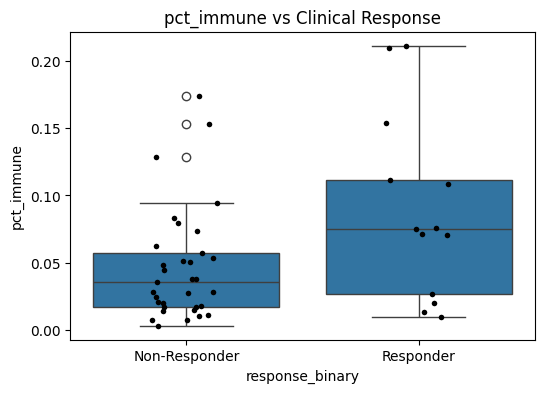

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(
    data=merged_df,
    x="response_binary",
    y="pct_immune"
)
sns.stripplot(
    data=merged_df,
    x="response_binary",
    y="pct_immune",
    color="black",
    jitter=0.15,
    size=4
)
plt.xticks([0,1], ["Non-Responder", "Responder"])
plt.title("pct_immune vs Clinical Response")
plt.show()


In [20]:
from scipy.stats import mannwhitneyu

resp = merged_df[merged_df["response_binary"] == 1]["pct_immune"]
nonresp = merged_df[merged_df["response_binary"] == 0]["pct_immune"]

stat, p = mannwhitneyu(resp, nonresp, alternative='two-sided')

print("Mann–Whitney U p-value:", p)


Mann–Whitney U p-value: 0.050979185876723544


In [23]:
from sklearn.metrics import roc_curve, auc

y_true = merged_df["response_binary"].values
y_score = merged_df["pct_immune"].values

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

print("AUC:", roc_auc)

AUC: 0.6876456876456877


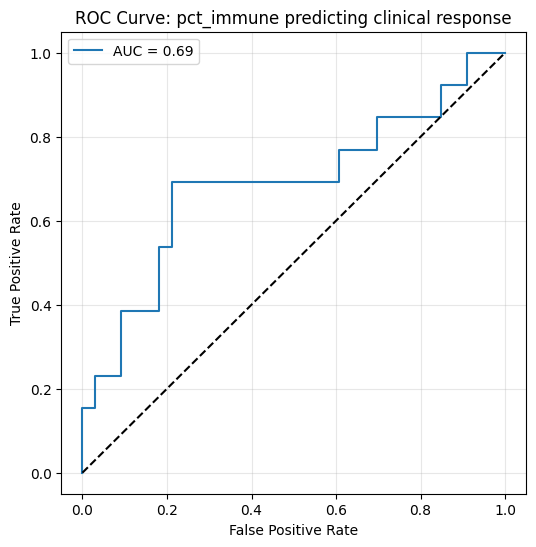

In [24]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: pct_immune predicting clinical response")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [25]:
import statsmodels.api as sm

X = merged_df[["pct_immune"]]
X = sm.add_constant(X)
y = merged_df["response_binary"]

model = sm.Logit(y, X).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.533661
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        response_binary   No. Observations:                   46
Model:                          Logit   Df Residuals:                       44
Method:                           MLE   Df Model:                            1
Date:                Wed, 10 Dec 2025   Pseudo R-squ.:                  0.1037
Time:                        12:13:09   Log-Likelihood:                -24.548
converged:                       True   LL-Null:                       -27.388
Covariance Type:            nonrobust   LLR p-value:                   0.01716
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8779      0.565     -3.324      0.001      -2.985      -0.771
pct_immune    14.6343      6.

In [26]:
best_idx = (tpr - fpr).argmax()
best_threshold = thresholds[best_idx]
print("Optimal threshold:", best_threshold)


Optimal threshold: 0.07075215669918908


In [27]:
merged_df["predicted_response"] = (merged_df["pct_immune"] > best_threshold).astype(int)
accuracy = (merged_df["predicted_response"] == merged_df["response_binary"]).mean()
print("Accuracy at optimal threshold:", accuracy)


Accuracy at optimal threshold: 0.7391304347826086


In [29]:
model_prediction = "/Users/jamesbolepan/Documents/cancer-immune-simulations/final_report_drug_modeling_counterfactual_minpath/per_sample_predictions.csv"
df_model = pd.read_csv(model_prediction)
df_model = df_model[["sample_id", "pred_drug", "y_true"]]

In [30]:
df_model.head()

,sample_id,pred_drug,y_true
0,2e83_08,1,1
1,2e75_11,0,0
2,2e77_15,0,0
3,2e77_08,0,1
4,2e79_11,0,0


In [31]:
# Make sure slide ID columns match
df_model = df_model.rename(columns={"sample_id": "Slide.id.Ab"})

# Merge with pct_immune dataframe
df_compare = merged_df.merge(df_model, on="Slide.id.Ab", how="inner")

print(df_compare.head())
print(df_compare.shape)


  Slide.id.Ab  total_cancer  total_immune  total_drug  pct_cancer  pct_immune  \
0     2e77_08     1283615.0       34862.0         0.0    0.973559    0.026441   
1     2e77_09     1408119.0      108665.0         0.0    0.928358    0.071642   
2     2e81_01       14245.0         209.0         0.0    0.985540    0.014460   
3     2e79_08     1015244.0       87633.0         0.0    0.920541    0.079459   
4     2e83_07      111666.0        4168.0         0.0    0.964017    0.035983   

  Response  response_binary  predicted_response  pred_drug  y_true  
0        R                1                   0          0       1  
1        R                1                   1          1       1  
2       NR                0                   0          0       0  
3       NR                0                   1          0       0  
4       NR                0                   0          0       0  
(46, 11)


In [32]:
y_true = df_compare["response_binary"].values

# AUC for pct_immune
fpr1, tpr1, thr1 = roc_curve(y_true, df_compare["pct_immune"])
auc_immune = auc(fpr1, tpr1)
print("AUC pct_immune:", auc_immune)


AUC pct_immune: 0.6876456876456877


In [33]:
# AUC for model prediction
fpr2, tpr2, thr2 = roc_curve(y_true, df_compare["pred_drug"])
auc_pred = auc(fpr2, tpr2)
print("AUC pred_drug:", auc_pred)


AUC pred_drug: 0.648018648018648


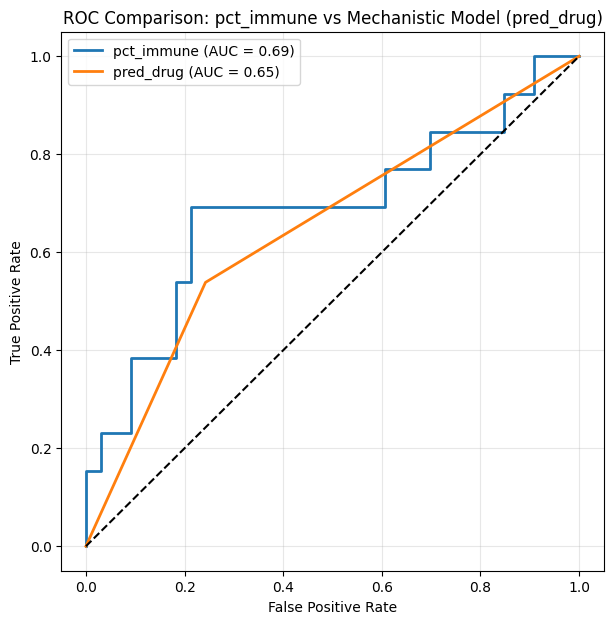

In [34]:
plt.figure(figsize=(7,7))

plt.plot(fpr1, tpr1, label=f"pct_immune (AUC = {auc_immune:.2f})", lw=2)
plt.plot(fpr2, tpr2, label=f"pred_drug (AUC = {auc_pred:.2f})", lw=2)

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison: pct_immune vs Mechanistic Model (pred_drug)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [37]:
agree = (df_compare["predicted_response"] == df_compare["pred_drug"]).mean()
print("Agreement rate:", agree)

Agreement rate: 0.6956521739130435


In [39]:
import pandas as pd

cm = pd.crosstab(
    df_compare["predicted_response"],
    df_compare["pred_drug"],
    rownames=["pct_immune prediction"],
    colnames=["mechanistic pred_drug"]
)

print(cm)


mechanistic pred_drug   0  1
pct_immune prediction       
0                      24  7
1                       7  8


In [40]:
import pandas as pd

cm_immune = pd.crosstab(
    df_compare["response_binary"],        # ground truth
    df_compare["predicted_response"],     # pct_immune prediction
    rownames=["Ground truth"],
    colnames=["Predicted (pct_immune)"]
)

print("Confusion Matrix: pct_immune vs Ground Truth")
print(cm_immune)


Confusion Matrix: pct_immune vs Ground Truth
Predicted (pct_immune)   0  1
Ground truth                 
0                       26  7
1                        5  8


In [42]:
cm_pred_drug = pd.crosstab(
    df_compare["response_binary"],        # ground truth
    df_compare["pred_drug"],          # mechanistic prediction (binary)
    rownames=["Ground truth"],
    colnames=["Predicted (pred_drug)"]
)

print("Confusion Matrix: pred_drug vs Ground Truth")
print(cm_pred_drug)


Confusion Matrix: pred_drug vs Ground Truth
Predicted (pred_drug)   0  1
Ground truth                
0                      25  8
1                       6  7
